# VMware Barcelona Hackathon 2023

# Sentiment analysis model

## Setup

In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import keras_tuner
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.saving import load_model
from sklearn.metrics import confusion_matrix

Using TensorFlow backend


## Load data

In [ ]:
df_main_r = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/Training_data/Reddit_Data.csv")
df_main_t = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/Training_data/Twitter_Data.csv")

df_main_t = df_main_t.rename(columns={"clean_text": "text"})

df_main_r = df_main_r.rename(columns={"clean_comment": "text"})


df_main = pd.concat([df_main_t, df_main_r])
df_main = df_main.sample(frac=1, random_state=42)

#df_main["text"] = df_main["text"].astype(str)

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200229 entries, 31537 to 121958
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   text      200125 non-null  object 
 1   category  200222 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.6+ MB


In [ ]:
df_main["category"].unique()

array([ 1.,  0., -1., nan])

In [ ]:
# Drop rows with null category (only 7)
df_main.dropna(inplace = True)

## Token encoding text

For the parameter max_len (max number of words kept per text) we check the words per text distribution

In [ ]:
words_per_text = df_main["text"].str.split().str.len()
print(words_per_text.describe())
max_text_len = int(words_per_text.quantile(0.995))
print(max_text_len)
# With 151 words per text we keep all words in 99.5% of texts

count    200222.000000
mean         21.800596
std          26.529232
min           0.000000
25%          10.000000
50%          18.000000
75%          29.000000
max        1307.000000
Name: text, dtype: float64
151


In [ ]:
#Total of words
words_per_text.sum()

4364959

In [ ]:
df_main["text"]

31537     another years bjp modi and hindu nationalism w...
147887    bjp are giving priority development narendra m...
87523     its known fact that missionaries are funding f...
45173     india has attained antisatellite capability be...
99538     dont ask modi apple pass kiya hai ask that duf...
                                ...                        
119879    how tragic that you are delighted this serious...
103694     wuld like read modi interview swarajya magazine 
131932    hurt telugu pride our leader has been humiliat...
146867    fan fully support conversion cause but modi go...
121958    fifth generation family making same promise er...
Name: text, Length: 200222, dtype: object

To study the number of unique words we will keep for our model

In [ ]:
# Initialise tokenizer
tokenizer = Tokenizer(split = " ")

# Fit tokeniser on the text data
tokenizer.fit_on_texts(df_main["text"].values)

# Retrieve word counts
word_counts = tokenizer.word_counts

# Sort word counts by frequency
word_frequency = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

print(len(word_frequency))
max_words = int(len([(i,j) for (i,j) in word_frequency if j >= 50]))

# So we choose to keep the most common 6479 words, removing the usage of words that appear
# less than 50 times out of a total 4364959 words (139559 different words)

139559


In [ ]:
print(max_words)
print(max_text_len)

6479
151


In [ ]:
def convert_text_to_seq(data):
  tokenizer = Tokenizer(num_words = max_words, split = " ")
  tokenizer.fit_on_texts(data["text"].values) # Transforms text into sequences of integers (the integers are the num_words by ascending order of frequency)
  sequences = tokenizer.texts_to_sequences(data["text"].values)

  with open("/content/drive/MyDrive/Colab Notebooks/NLP/tokenizer_new.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  return pad_sequences(sequences, maxlen = max_text_len)

X = convert_text_to_seq(df_main)

In [ ]:
X.shape # So 200222 elements having 151 integers each one

(200222, 151)

## Split the data in train and test

In [ ]:
df_main_prossed["category"]

In [ ]:
y = pd.get_dummies(df_main["category"]).values

X_train, X_test, y_train, y_test = train_test_split(X , y, train_size = 0.8, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(170188, 151) (170188, 3)
(30034, 151) (30034, 3)


## Define and train model

After triying different architectures we keep one that balances learning the patterns in the data but not so much that it overfits on the training set. That happends when we increase too much the complexity of the neural network.

In [ ]:
def get_model(lstm_dropout, l_dropout):
  model = Sequential()
  model.add(layers.Embedding(max_words, 32, input_length = max_text_len))
  model.add(layers.Bidirectional(layers.LSTM(16,dropout=lstm_dropout)))
  model.add(layers.Dense(12,activation="relu"))
  model.add(layers.Dropout(l_dropout))
  model.add(layers.Dense(8,activation="relu"))
  model.add(layers.Dropout(l_dropout))
  model.add(layers.Dense(3,activation="softmax"))
  model.compile(optimizer="Adam",loss="categorical_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
early_stopping = EarlyStopping(monitor="accuracy", patience = 5, mode="max", verbose=2)
early_stopping_val = EarlyStopping(monitor="val_accuracy", patience = 3, mode="max", verbose=2)

lstm_dropout = 0.2
l_dropout = 0.2

In [ ]:
model = get_model(lstm_dropout, l_dropout)
model.summary()
history = model.fit(X_train, y_train, validation_split = 0.25, callbacks = [early_stopping, early_stopping_val], epochs = 25, batch_size = 64)

In [ ]:
#model.save("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/final_sentiment_model", save_format = "tf")

In [ ]:
#model = load_model("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/final_sentiment_model")

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 151, 32)           207328    
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
 dropout_2 (Dropout)         (None, 12)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                      

Text(0.5, 1.0, 'Model training')

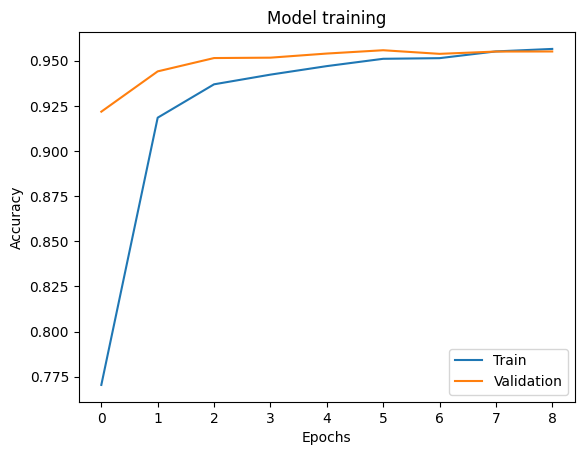

In [ ]:
# Plot the training session
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model training")

## Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 2)

939/939 - 16s - loss: 0.2155 - accuracy: 0.9523 - 16s/epoch - 17ms/step


In [ ]:
y_pred = model.predict(X_test)

939/939 [==============================] - 22s 24ms/step


In [ ]:
y_pred

array([[2.5710913e-03, 9.9257833e-01, 4.8506246e-03],
       [2.1450557e-03, 9.9366778e-01, 4.1871415e-03],
       [3.2713117e-06, 9.9997526e-01, 2.1490841e-05],
       ...,
       [6.0997624e-04, 1.3616667e-05, 9.9937648e-01],
       [1.3548072e-08, 2.4644286e-12, 1.0000000e+00],
       [1.9436966e-06, 3.2863909e-09, 9.9999809e-01]], dtype=float32)

In [ ]:
y_test

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

To produce a confusion matrix we need to get y_pred to have rows with a 1 in the class with the biggest predicted probability and 0 in the rest. Then we put y_pred and y_test respectivelly in a 1D array where each position can be 0, 1 or 2 depending on the class with the highest probability.  

In [ ]:
y_pred_1d = np.argmax(y_pred, axis = 1)
y_test_1d = np.argmax(y_test, axis = 1)

In [ ]:
conf_matrix

array([[ 6008,   180,   425],
       [  105, 10074,   127],
       [  416,   180, 12519]])

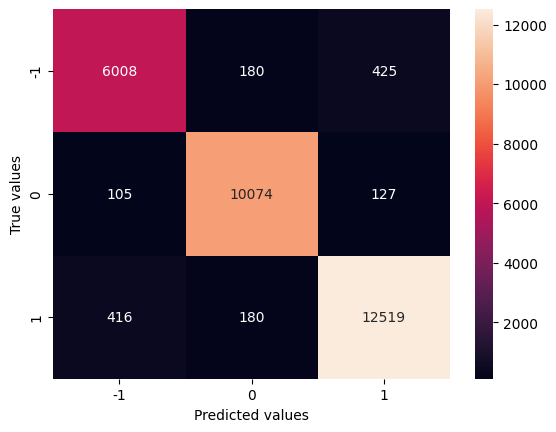

In [ ]:
conf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
conf_matrix_plot(conf_matrix, ["-1", "0" , "1"])

In [ ]:
def conf_matrix_plot(conf_matrix, tags, fmt='d'):
    plt.figure()
    sns.heatmap(conf_matrix, annot = True, fmt = fmt, cbar = True, xticklabels = tags, yticklabels = tags)
    plt.yticks(rotation = 90)
    plt.xlabel("Predicted values")
    plt.ylabel("True values")
    plt.show()

We have obtained validation and test accuracy of around 95%. Looking at the confusion matrix we can see there is no particular category for which our model performs worse. This high quality sentiment analysis model will help contribute to the success of the demo.  